#### Exploring and transforming canned craft beer data

These datasets contain data on 2,410 US craft beers and 510 US craft breweries. The data was collected by CraftCans.com in 2017. This data was pulled from Kaggle, linked [here.](https://www.kaggle.com/datasets/nickhould/craft-cans/data)

The goal of this Jupyter Notebook is to practice data transformation and cleaning, perform exploratory data analysis, and create visually appealing graphics to enable insightful analysis.

While exploring this dataset, there are a few limitations that should be pointed out:
- Scope of Beers Represented: This data was captured by a canned beer website, so it only contains data about canned beers. It doesn't capture the full scope of craft beer sales or consumption across the USA.
- Incomplete Craft Brewery Snapshot: This dataset doesn’t provide a comprehensive overview of all beers and breweries in the USA in 2017. For example, while it lists Colorado as having the highest number of breweries (almost 50), other sources report that California alone had over 900 breweries by 2017 source.

Despite these limitations, this dataset offers a fun and interesting opportunity for practice and exploration!

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import warnings
import os
import re

warnings.filterwarnings('ignore')

# Helper function to read a CSV file from the current working directory
def read_csv_from_cwd(filename):
    return pd.read_csv(os.path.join(os.getcwd(), 'Inputs', filename))

# Read the CSV files
df_beers = read_csv_from_cwd('beers.csv')
df_breweries = read_csv_from_cwd('breweries.csv')

### An Initial Look at the Data

In [3]:
# How big are each of these datasets?
print('beers dataset length & number of columns:', df_beers.shape)
print('breweries dataset length & number of columns:' , df_breweries.shape)

beers dataset length & number of columns: (2410, 7)
breweries dataset length & number of columns: (558, 3)


In [4]:
df_beers.head()

,abv,ibu,id,name,style,brewery_id,ounces
0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


In [5]:
df_breweries.head()

,name,city,state
0,NorthGate Brewing,Minneapolis,MN
1,Against the Grain Brewery,Louisville,KY
2,Jack's Abby Craft Lagers,Framingham,MA
3,Mike Hess Brewing Company,San Diego,CA
4,Fort Point Beer Company,San Francisco,CA


In [6]:
# What datatypes are the fields in these datasets?
print(df_beers.info())
print(df_breweries.info())

# Initial summary statistics for the beers dataset
round(df_beers[['abv', 'ibu', 'ounces']].describe(include='all'), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   abv         2348 non-null   float64
 1   ibu         1405 non-null   float64
 2   id          2410 non-null   int64  
 3   name        2410 non-null   object 
 4   style       2405 non-null   object 
 5   brewery_id  2410 non-null   int64  
 6   ounces      2410 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 131.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    558 non-null    object
 1   city    558 non-null    object
 2   state   558 non-null    object
dtypes: object(3)
memory usage: 13.2+ KB
None


,abv,ibu,ounces
count,2348.00,1405.00,2410.00
mean,0.06,42.71,13.59
std,0.01,25.95,2.35
min,0.00,4.00,8.40
25%,0.05,21.00,12.00
50%,0.06,35.00,12.00
75%,0.07,64.00,16.00
max,0.13,138.00,32.00


In [7]:
# Where are the null values in the beer dataset and how many are there?
print(df_beers.isnull().sum())
print(df_breweries.isnull().sum())

abv             62
ibu           1005
id               0
name             0
style            5
brewery_id       0
ounces           0
dtype: int64
name     0
city     0
state    0
dtype: int64


### Data Cleaning

In [8]:
### Clean the beers dataset: address missing data in the beers dataset

# Group the beers data by beer style and get a mean value for ABV and IBU.
# means_bystyle will be used to inpute missing values in the beers dataset based on a beer's beer style
means_bystyle = df_beers.groupby(by='style', dropna=False).mean(numeric_only=True).drop(columns=['id', 'brewery_id', 'ounces']).reset_index()

# See which columns have null values to help identify missing data
print(means_bystyle.isnull().sum())

# See which styles are missing their IBUs
print(means_bystyle.query('ibu.isnull()'))

# Dictionary to fill missing IBU values based on beer style
ibu_fill_values = {
    'American Malt Liquor': 20,
    'Braggot': 30,
    'Cider': 0,
    'Flanders Red Ale': 15,
    'Kristalweizen': 15,
    'Low Alcohol Beer': 15,
    'Mead': 0,
    'Rauchbier': 25,
    'Shandy': 10
}

# Fill missing IBU values by mapping styles to the dictionary
means_bystyle['ibu'] = means_bystyle['ibu'].fillna(means_bystyle['style'].map(ibu_fill_values))

# Join ABV and ABU averages by style to main beer dataset
df_beers = pd.merge(df_beers, means_bystyle, on='style', how='left', suffixes=('', '_mean'))

# Impute style averages into null values in main beer dataset
df_beers['ibu'].fillna(df_beers['ibu_mean'], inplace=True)
df_beers['abv'].fillna(df_beers['abv_mean'], inplace=True)

# Drop columns used to insert average ABV and IBU for each beer style
df_beers = df_beers.drop(columns=['abv_mean', 'ibu_mean'])

# There are 5 beer entries where the beer style is null
print(df_beers[df_beers['style'].isna()])

# Two of these we can insert style data based on the actual beer name
df_beers.loc[df_beers['name'] == 'Kilt Lifter Scottish-Style Ale', 'style'] = "Scottish-Style Ale"
df_beers.loc[df_beers['name'] == 'OktoberFiesta', 'style'] = "Märzen / Oktoberfest"

# Drop the other three, because they appear to be neither valid nor useful records
df_beers.dropna(subset=['style'], inplace=True)



### Clean the breweries dataset

# The index of the brewery dataset is its brewery id, which will be used to merge brewery data into the beers data.
df_breweries['brewery_id'] = df_breweries.index

# Remove spacing before state codes
df_breweries['state'] = df_breweries['state'].str.strip()

style    1
abv      0
ibu      9
dtype: int64
                   style       abv  ibu
15  American Malt Liquor  0.099000  NaN
34               Braggot  0.075000  NaN
37                 Cider  0.060514  NaN
57      Flanders Red Ale  0.083000  NaN
68         Kristalweizen  0.045000  NaN
71      Low Alcohol Beer  0.001000  NaN
73                  Mead  0.071600  NaN
84             Rauchbier  0.060500  NaN
92                Shandy  0.045333  NaN
         abv   ibu    id                            name style  brewery_id  \
566   0.0565  24.0  2210                 Special Release   NaN          29   
853   0.0600  21.0  1635  Kilt Lifter Scottish-Style Ale   NaN         160   
866   0.0530  27.0  2527                   OktoberFiesta   NaN          66   
1554  0.0565  24.0  1796                    The CROWLER™   NaN         166   
1555  0.0565  24.0  1790            CAN'D AID Foundation   NaN         166   

      ounces  
566     16.0  
853     12.0  
866     12.0  
1554    32.0  
1555    12

### Join the datasets

In [9]:
# Bring in breweries data
df = pd.merge(df_beers, df_breweries, how='left', on='brewery_id')

# Rename columns, because both datasets have the same column header "name"
df = df.rename(columns={'abv':'ABV', 'ibu':'IBU', 'id':'beer_id', 'name_x':'Beer Name', 'style':'Beer Style', 'name_y':'Brewery Name', 'ounces':'oz', 'city':'City', 'state':'State'})

# Reorder columns
df = df.reindex(columns=['beer_id', 'brewery_id', 'Brewery Name', 'Beer Name', 'Beer Style', 'ABV', 'IBU', 'oz', 'City', 'State'])

# Take a look at the resulting dataframe
df.head()

,beer_id,brewery_id,Brewery Name,Beer Name,Beer Style,ABV,IBU,oz,City,State
0,1436,408,10 Barrel Brewing Company,Pub Beer,American Pale Lager,0.050,26.750000,12.0,Bend,OR
1,2265,177,18th Street Brewery,Devil's Cup,American Pale Ale (APA),0.066,44.941176,12.0,Gary,IN
2,2264,177,18th Street Brewery,Rise of the Phoenix,American IPA,0.071,67.634551,12.0,Gary,IN
3,2263,177,18th Street Brewery,Sinister,American Double / Imperial IPA,0.090,93.320000,12.0,Gary,IN
4,2262,177,18th Street Brewery,Sex and Candy,American IPA,0.075,67.634551,12.0,Gary,IN


### Visualization

Now that the data is cleaned up and joined, let's create some interesting visuals to point out some interesting facts and trends we can find within the data.

What State has the most breweries?

What are the average ABVs and IBUs by beer style?
    -ABV: Alcohol By volume
    -IBU: Internation Bittering Unit, IE how bitter the hops make the beer


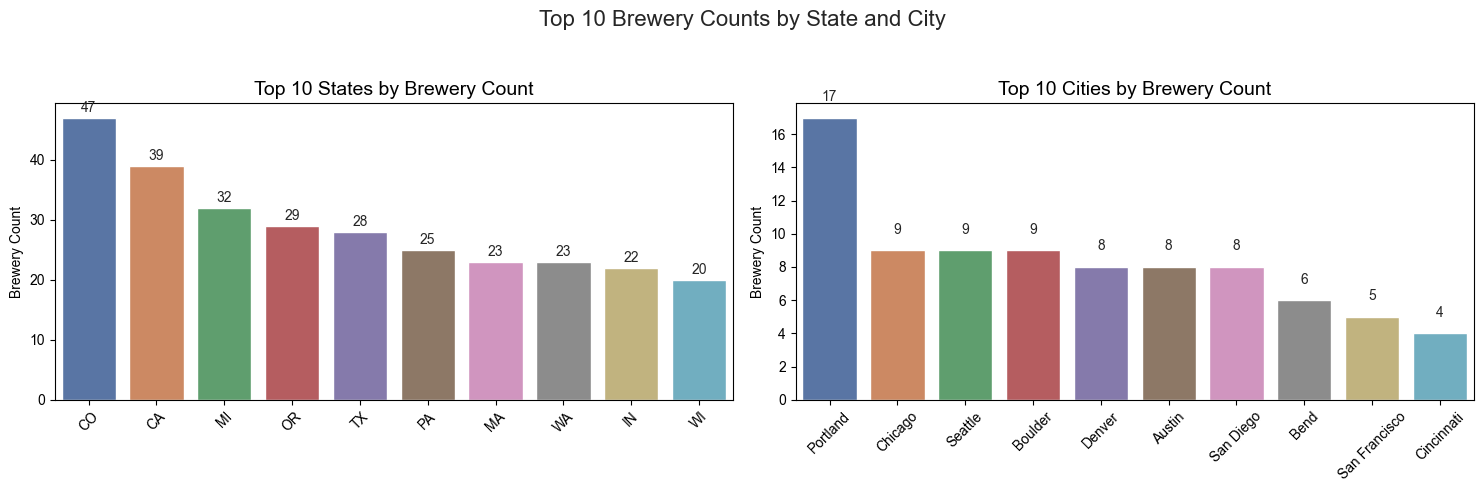

In [10]:
# Create data for a histogram showing the count of breweries by State and City
brewery_countsbystate = df_breweries['state'].value_counts().rename_axis('State').reset_index(name='Brewery Count')
brewery_countsbycity = df_breweries['city'].value_counts().rename_axis('City').reset_index(name='Brewery Count')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.set_theme(style="whitegrid")
fig.suptitle('Top 10 Brewery Counts by State and City', fontsize=16)

# Top 10 States
sns.barplot(ax=axes[0], x="State", y="Brewery Count", data=brewery_countsbystate.head(10), palette='deep')
axes[0].set_title("Top 10 States by Brewery Count", fontsize=14)
axes[0].set_ylabel("Brewery Count")
axes[0].set_xlabel("")  # Suppress bottom label
for i, value in enumerate(brewery_countsbystate['Brewery Count'].head(10)):
    axes[0].text(i, value + 1, f"{value}", ha='center', fontsize=10)  # Label each bar

# Top 10 Cities
sns.barplot(ax=axes[1], x="City", y="Brewery Count", data=brewery_countsbycity.head(10), palette='deep')
axes[1].set_title("Top 10 Cities by Brewery Count", fontsize=14)
axes[1].set_ylabel("Brewery Count")
axes[1].set_xlabel("")  # Suppress bottom label
for i, value in enumerate(brewery_countsbycity['Brewery Count'].head(10)):
    axes[1].text(i, value + 1, f"{value}", ha='center', fontsize=10)  # Label each bar

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Display the plots without printing extra output
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()


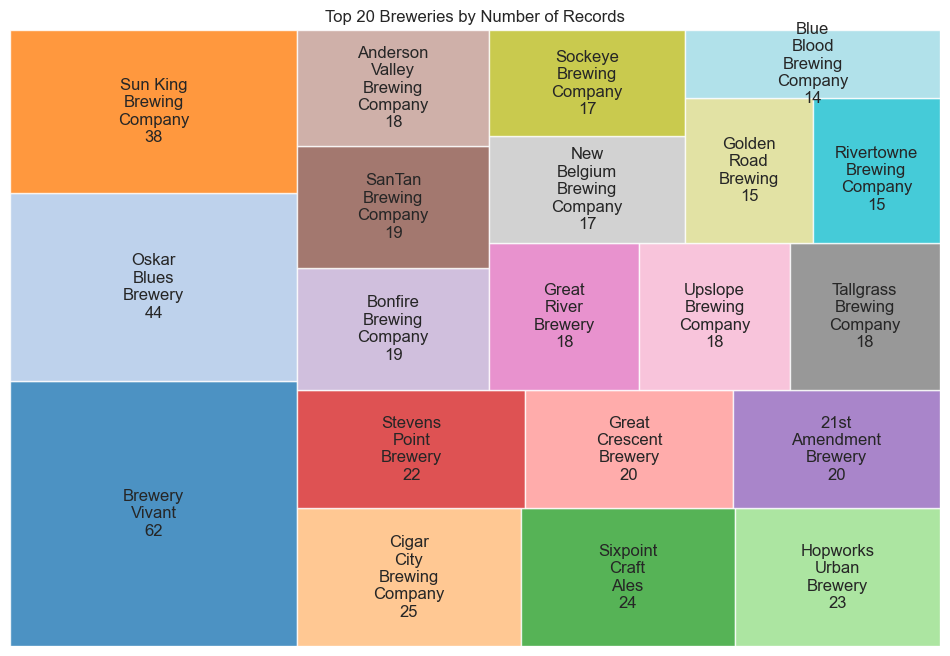

In [94]:
### Visualize the most popular breweries within the data
# Helper function to wrap text
def wrap_text(text, max_width=10):
    words = text.split()
    wrapped_text = ''
    line = ''
    for word in words:
        # Check if adding this word exceeds max width
        if len(line) + len(word) + 1 <= max_width:
            line += (word + ' ')
        else:
            wrapped_text += line.strip() + '\n'
            line = word + ' '
    wrapped_text += line.strip()
    return wrapped_text

# Count records for each brewery
top_breweries = df['Brewery Name'].value_counts().nlargest(20)
wrapped_labels = [f"{wrap_text(brewery)}\n{count}" for brewery, count in zip(top_breweries.index, top_breweries.values)]

# Plot the tree map
plt.figure(figsize=(12, 8))
squarify.plot(sizes=top_breweries.values, label=wrapped_labels, alpha=0.8, color=plt.cm.tab20.colors)
plt.axis('off')
plt.title('Top 20 Breweries by Number of Records')
plt.show()


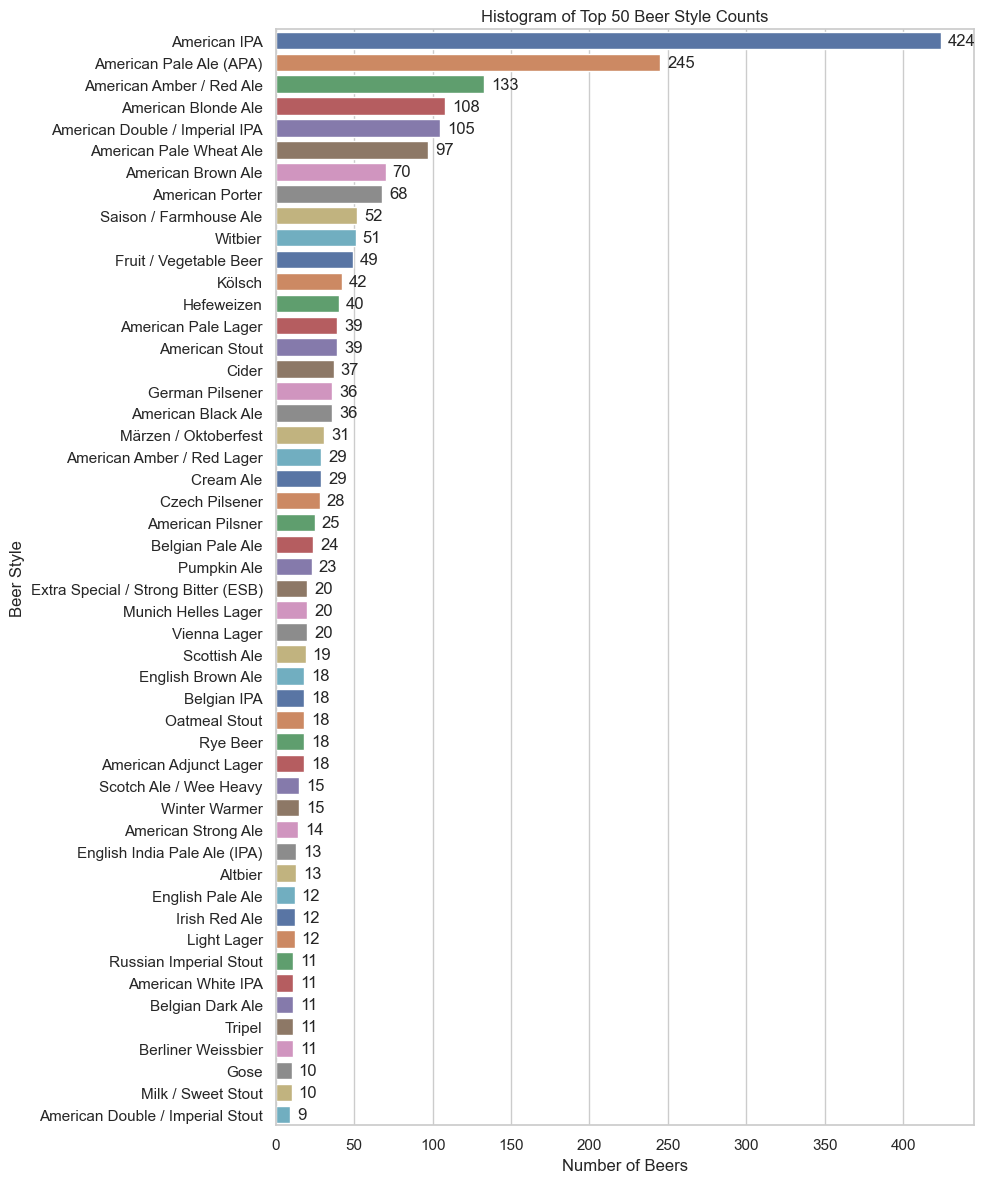

In [11]:
# Get the top 60 beer styles by count, sorted in descending order
top_50_styles = df["Beer Style"].value_counts().nlargest(50)

# Filter the data to include only the top 20 beer styles
df_top_20 = df[df["Beer Style"].isin(top_50_styles.index)]

# Ensure the Beer Style column is ordered in descending order for plotting
df_top_20["Beer Style"] = pd.Categorical(df_top_20["Beer Style"], categories=top_50_styles.index, ordered=True)

# Create the vertical (long) histogram for the top 20 beer styles
plt.figure(figsize=(10, 12))  # Increase height for a longer chart
ax = sns.countplot(y="Beer Style", data=df_top_20, order=top_50_styles.index, palette="deep", orient='h')  # Horizontal bars

# Add counts at the end of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=5)  # Adds the labels

plt.ylabel("Beer Style")
plt.xlabel("Number of Beers")
plt.title("Histogram of Top 50 Beer Style Counts")
plt.tight_layout()

# Display the histogram
plt.show()


### Insights about the beer styles shown above

This histogram shows that there's a wide range of specific beer styles within this data. Having the level of granularity is nice, but beer can be categorized into broader categories which we can find some insight into the popularity of each major beer category on the resulting information.

I am not surprised in the least that the largest two styles are American IPA and American Pale Ale. These are quite a common beer styles and most breweries have several different beers that fall into these categories.

I noticed that the style "American pale Wheat Ale" has a large count of beers. These beers could be grouped into either the wheat ale or the pale ale/IPA category, but I think they should go under the wheat ale category, because the addition of wheat to the recipe makes it unique to the broader wheat ale category.

I will write some code that searches for certain words within the field "beer style" that group them into a specific and broader category. Below I will provide a definition of each category and what kinds of beers will be found in each category.


### ABV and IBU column Definitions to help give context for information below:
- ABV: Alcohol by volume. IE how much alcohol is in a beer per liquid ounce.

- IBU: International Bittering Unit. IE the level of bitterness found in the liquid. This is measured using a Spectrophotometer.


### Below are descriptions for the broader beer style categories we will group by.

IPA / Pale Ale: India Pale Ales and Pale Ales are hop-forward beers, known for their bold bitterness and vibrant hop flavors, which can range from citrusy and fruity to piney and floral. They come in several substyles, including American IPA, Double/Imperial IPA, Pale Ale, New England IPA, and Belgian Pale Ale, each varying in alcohol content and level of hops / IBUs.

Lager / Dark Lager / Lager Hybrid: Lagers are fermented at cooler temperatures, creating a clean, crisp profile. Dark lagers include styles like bocks and schwarzbiers, which have richer malty, roasty, chocolatey flavors while still having a light body and mouthfeel. Lager hybrids such as Kölsch or Altbier blend lager fermentation methods with ale yeast, offering rich flavors that an ale offers, while still having the light bodied characteristics of a lager.

Malt: Beers in the malt-forward category emphasize the sweetness and richness of malted barley. This category includes amber ales, red ales, mild ales, and English bitters, with flavors of caramel, toffee, bread, and sometimes a slight nuttiness. These beers balance sweetness with a soft bitterness, making them approachable and complex.

Dark / Malt / Roast: These beers focus on rich, roasted malt flavors, creating dark and full-bodied brews with notes of coffee, chocolate, and roasted nuts. Examples include stouts, porters, black ales and smoked beers. They range from dry, bitter stouts like Irish stouts to sweeter, more robust styles like imperial stouts. These beers are all considered ales, because dark lagers were captured in the lager category.

Blonde / Wheat / Light Ale: This category includes blonde ales, wheat beers, and other light-bodied, easy-drinking styles. Blonde ales are mild and slightly malty, while wheat beers, such as hefeweizens and witbiers, often have fruity, spicy flavors from the yeast (like banana or clove) and a soft, cloudy appearance. These beers are refreshing and light, making them perfect for warmer weather.

Fruit / Fruited / Spiced / Cider: These beers incorporate fruits, spices, or other flavorings into the brewing process. Fruit beers often feature berries, citrus, or tropical fruits, while spiced beers might include ingredients like cinnamon, nutmeg, or ginger. Ciders fall into this category as well, offering a crisp, apple-based alternative to traditional beer.

Pale Wheat Ale: Pale wheat ales are lighter, crisper versions of traditional wheat beers. They often have subtle malt sweetness with a more hop-forward profile than other wheat beers. These beers still have the signature smoothness and haze from the wheat but offer a lighter, refreshing experience with a slightly more bitter finish due to a heavier hop bill.

Funky / Sour / Saison: This category includes beers that are known for their tartness, funkiness, or rustic character. Sour beers (like gose or berliner weisse) are often brewed with wild yeasts or bacteria, giving them a sharp, tangy flavor. Saisons and farmhouse ales can have earthy, estery, spicy, or fruity notes, with a dry finish and sometimes a touch of funk from wild yeast strains.

High ABV / Strong Ale: Strong ales are characterized by their high alcohol content and bold flavors. Styles like barleywines, imperial stouts, and Belgian strong ales have a rich, malty backbone with flavors of caramel, dark fruit, and warming alcohol. These beers are typically full-bodied and sipped slowly to appreciate their complexity.

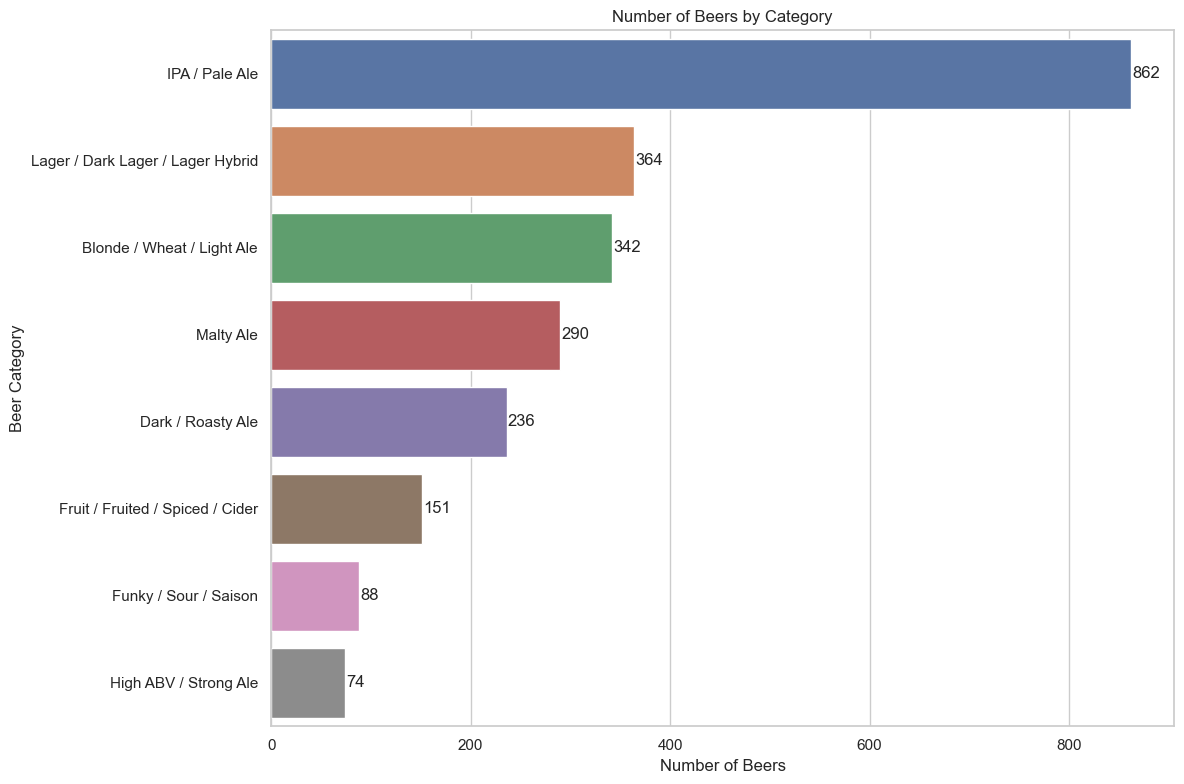

In [76]:
# Define the function to classify beer styles
def classify_beer_style(style):
    style_lower = style.lower()
    categories = {
        'IPA / Pale Ale': r'(ipa|pale)(?!.*wheat|.*lager)',
        'Lager / Dark Lager / Lager Hybrid': r'(lager|pilsner|pilsener|bock|kölsch|oktober|schwarz|altbier|märzen|low alcohol)',
        'Malty Ale': r'(malt|rye|red|brown|amber|dubbel|dunkel|keller|esb|bitter|roggen)',
        'Blonde / Wheat / Light Ale': r'(wheat|wit|cream|hefe|weizen|blonde|abbey|common)',
        'Dark / Roasty Ale': r'(stout|porter|dark|black|rauch|smoke)',
        'Fruit / Fruited / Spiced / Cider': r'(fruit|spice|cider|pumpkin|old|braggot|mead|warmer|shandy|radler|chile|other)',
        'High ABV / Strong Ale': r'(strong|barleywine|tripel|quad|scott|wee|heavy)',
        'Funky / Sour / Saison': r'(gose|wild|berliner|saison|farm|garde|grisette|flanders|bruin)',
    }
    
    for category, pattern in categories.items():
        if re.search(pattern, style_lower):
            return category
    return 'Other'

# Create a new column for beer category based on the style
df['Beer Category'] = df['Beer Style'].apply(classify_beer_style)

# Function to plot beer category counts with custom tick labels
def plot_beer_categories(counts):
    plt.figure(figsize=(12, 8))
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(y=counts.index, x=counts.values, palette="deep")
    
    # Adding count labels on each bar
    for i, value in enumerate(counts.values):
        ax.text(value + 1, i, f"{value}", va='center')  # Labels slightly offset to the right of the bar

    # Setting custom x-axis tick labels with thousands separators
    ax.set_xticklabels([f"{int(x):,}" for x in ax.get_xticks()])

    plt.ylabel("Beer Category")
    plt.xlabel("Number of Beers")
    plt.title("Number of Beers by Category")
    plt.tight_layout()
    plt.show()

# Count the occurrences of each beer category
beer_category_counts = df['Beer Category'].value_counts()

# Plot the histogram for the different beer categories
plot_beer_categories(beer_category_counts)



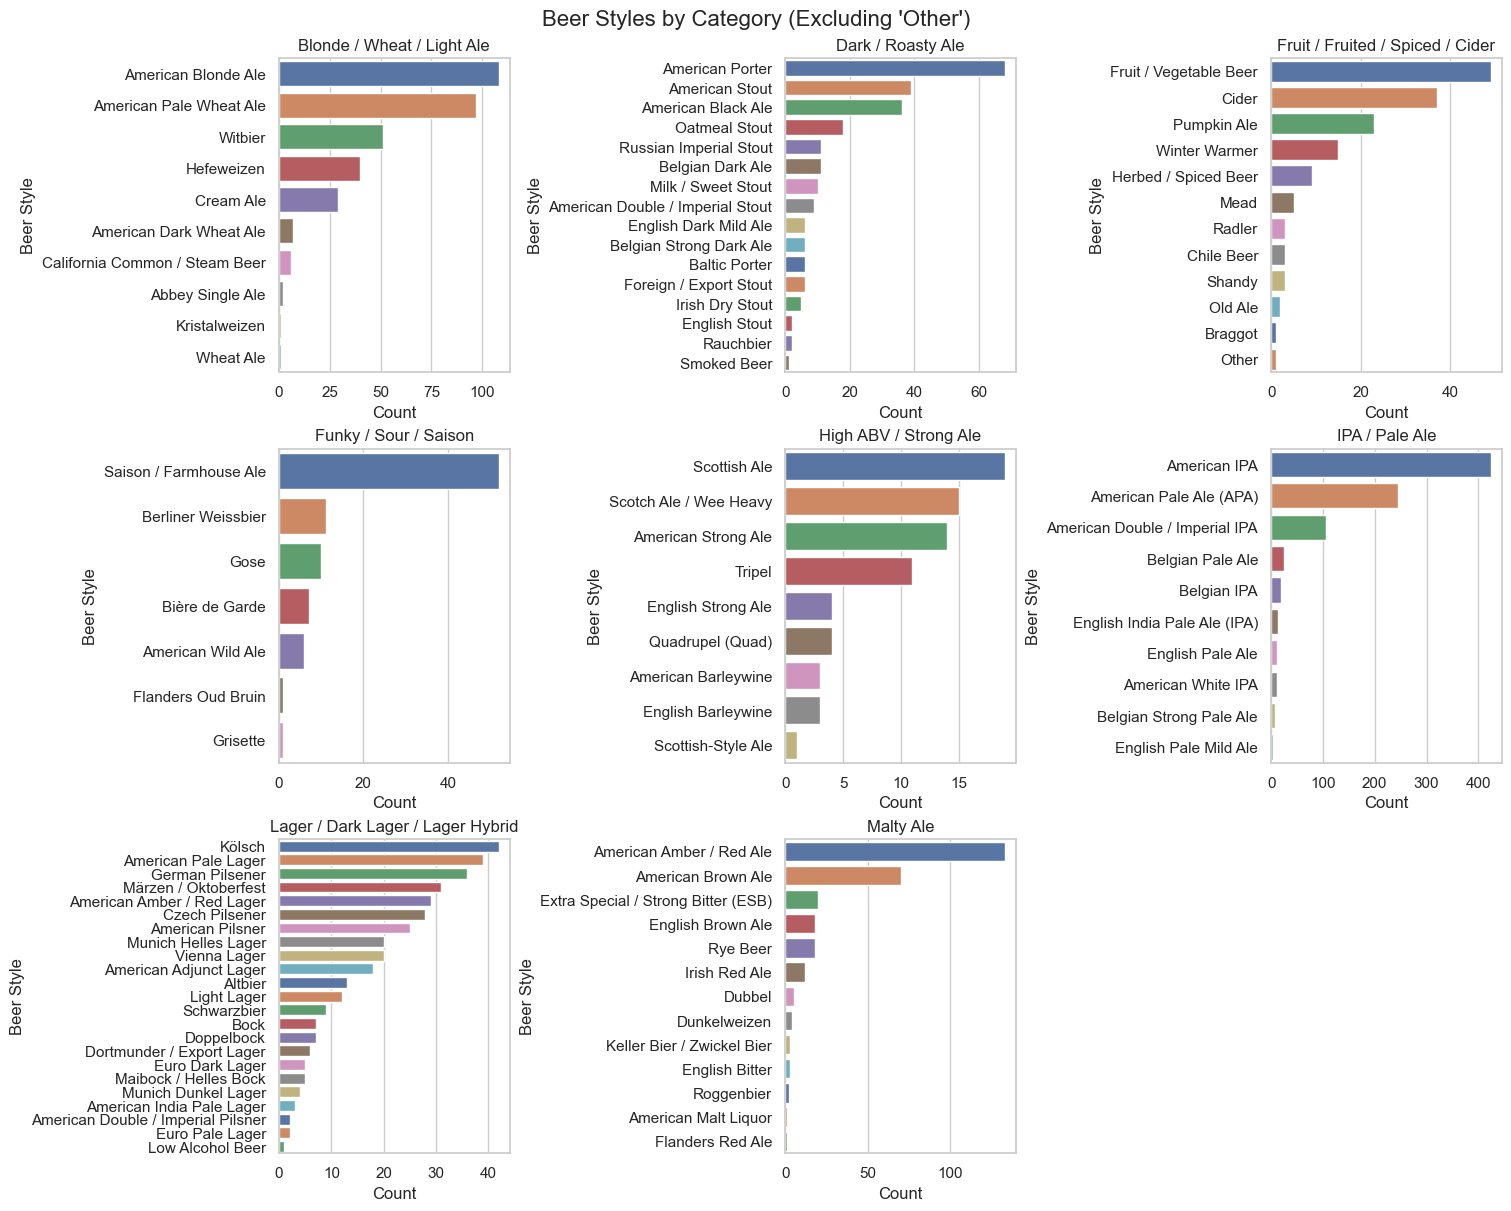

In [77]:
# Count beer styles within each category
beer_style_counts = df.groupby(['Beer Category', 'Beer Style']).size().reset_index(name='Count')

# Calculate total count of beers for each category
category_totals = beer_style_counts.groupby('Beer Category')['Count'].sum().sort_values(ascending=False)

# Sort the beer_style_counts based on the total count of beers per category
sorted_data = beer_style_counts.set_index('Beer Category').loc[category_totals.index].reset_index()

# Set up the grid size based on the number of unique categories
n_categories = sorted_data['Beer Category'].nunique()
n_cols = 3  # Number of columns in the grid
n_rows = (n_categories // n_cols) + (n_categories % n_cols > 0)

# Set up the figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), constrained_layout=True)
axes = axes.flatten()

# Plot each Beer Category in its own subplot
for i, (category, group) in enumerate(sorted_data.groupby('Beer Category')):
    # Sort styles within each category by count in descending order
    group = group.sort_values('Count', ascending=False)
    ax = axes[i]
    sns.barplot(data=group, x='Count', y='Beer Style', ax=ax, palette="deep")
    ax.set_title(category)
    ax.set_xlabel("Count")
    ax.set_ylabel("Beer Style")

# Hide any unused subplots if the grid is larger than the number of categories
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Display the grid of bar charts
plt.suptitle("Beer Styles by Category (Excluding 'Other')", fontsize=16)
plt.show()


#### Looking at the major beer categories broken down this way, we see that:
- Both Roasty Ales and Lagers have a wide range of different specific beer styles. There are a lot of very specific beer styles you can do with these styles, depending on what blend of yeast, malt, and hops a brewer uses.
- It comes as no surprise that American IPA takes the cake in the IPA/Pale ale category. American IPA and American Pale Ale most certinly are the most commonly found canned style of craft beer in the USA.
- It's interesting to see that red ale, american porter, and saison have a large count of beers within this data.
- I am surprised that most the the wheat beers are categorized as "pale" wheat. A "wheat beer" (think Blue Moon or Allagash White) is the more common beer style than pale wheat.


#### Below are some summary statistics for each major beer category, as well as a scatter plot for ABV and IBU.
- It comes as no surprise that Strong, Roasty, and Pale Ales contain the higher average ABVs. These beers are brewed with a hefty malt bill to balance out the generous amount of hops used.
- IPAs take the lead with IBU's, which tracks for the style of beer. More hops are used in IPAs and pale ales, so naturally the IBUs will be higher
- The graph below proves the point that, as a beer's ABV gets higher, its IBUs will also naturally be higher. This is because beers with higher ABV have more malt, and to balance out that sweetness/maltiness, more hops need to be in the recipe.
- Calling out the largest outliers on the graph, it makes sense to see what outliers we get. There are some Double IPAs out there that have a giant amount hops added to them and also have a high ABV. I also see a Belgian Quad, a stout, and a barleywine, which are typically very thick, sweet, rich beers with a heavy malt bill.
- Conversely, a radler would naturally be on the low end of the spectrum, as a radler is a low ABV beer mixed with a lemonade.

In [78]:
# Group by 'Beer Category' and calculate the required statistics
# sort the data by highest average alcohol content
category_stats = df.groupby('Beer Category').agg(
    total_count=('Beer Category', 'size'),           # Total count of beers in each category
    avg_abv=('ABV', 'mean'),                        # Average ABV for each category
    std_abv=('ABV', 'std'),                         # Standard deviation of ABV
    avg_ibu=('IBU', 'mean'),                        # Average IBU for each category
    std_ibu=('IBU', 'std')                          # Standard deviation of IBU
).round(3).sort_values(by='avg_abv', ascending=False).reset_index()

# Format ABV as a percentage (multiply by 100 and add '%' sign)
category_stats['avg_abv'] = category_stats['avg_abv'].apply(lambda x: f"{x * 100:.1f}%")
category_stats['std_abv'] = category_stats['std_abv'].apply(lambda x: f"{x * 100:.1f}%")

# Print the summary statistics
category_stats

,Beer Category,total_count,avg_abv,std_abv,avg_ibu,std_ibu
0,High ABV / Strong Ale,74,7.9%,1.6%,38.785,23.297
1,Dark / Roasty Ale,236,6.6%,1.5%,44.008,20.614
2,IPA / Pale Ale,862,6.4%,1.3%,61.408,20.928
3,Fruit / Fruited / Spiced / Cider,151,5.8%,1.2%,14.058,11.445
4,Malty Ale,290,5.8%,1.0%,34.253,14.773
5,Funky / Sour / Saison,88,5.8%,1.3%,23.039,9.004
6,Lager / Dark Lager / Lager Hybrid,364,5.2%,0.9%,25.477,10.579
7,Blonde / Wheat / Light Ale,342,5.0%,0.7%,20.220,7.699


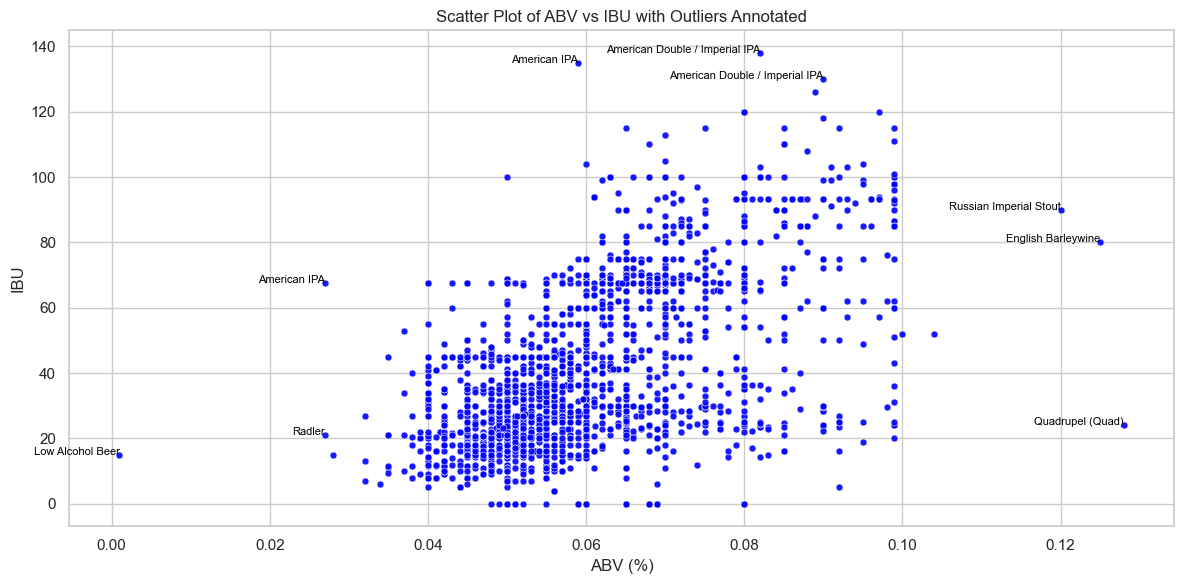

In [84]:
# Set the Seaborn style to 'whitegrid'
sns.set_theme(style="whitegrid")

# Define thresholds for outliers
# Top 5% (high outliers) and bottom 5% (low outliers) for both ABV and IBU
abv_high_threshold = df['ABV'].quantile(0.999)
abv_low_threshold = df['ABV'].quantile(0.001)
ibu_high_threshold = df['IBU'].quantile(0.999)
ibu_low_threshold = df['IBU'].quantile(0.001)

# Identify outliers for both high and low ends
outliers = df[(df['ABV'] > abv_high_threshold) | 
              (df['ABV'] < abv_low_threshold) |
              (df['IBU'] > ibu_high_threshold) | 
              (df['IBU'] < ibu_low_threshold)]

# Create a wider scatter plot without the gradient
plt.figure(figsize=(12, 6))

# Scatter plot with smaller, bold points (no gradient)
sns.scatterplot(x='ABV', y='IBU', data=df, color='blue', alpha=0.9, s=25)

# Add labels and title
plt.xlabel('ABV (%)')
plt.ylabel('IBU')
plt.title('Scatter Plot of ABV vs IBU with Outliers Annotated')

# Annotate outliers with their beer style
for _, row in outliers.iterrows():
    plt.text(row['ABV'], row['IBU'], row['Beer Style'], 
             color='black', fontsize=8, ha='right')

# Show the plot with tight layout
plt.tight_layout()
plt.show()
